# 1. Introduction

This is a dataset for the credit card fraud transaction detection. It contains synthetic data for the [Capital One](https://www.capitalone.com/) Data Scientist Recruiting process.

## 1.1. Objective
- It's a binary classification problem where we need to predict whether a transaction is a fraud or not.
- Our business sense making purpose should be to minimize the total loss dollar amount due to fraud with the most parsimonious total number of transactions flagged as suspicious. In this way, the non-fraud real business transactions will be exposed to the minimal level of impact possible. In another word, we'd like to achieve a balance between precision and recall, so F1-score will be used as the leading metric.

## 1.2. Data Description
- The dataset is saved in the JSON format in a .txt file and will render a dataframe with a fair dimension of 786,363 x 29 after loading.
- The label (isFraud) is hugely imbalanced with less than 2% of fraudulent transactions. We'd use both undersample the non-fraud transactions and oversample the fraud transactions to deal with the imbalance issue and compare their performances. 
- 

# 2. Module Management, Data Import

Since the dataset is in the JSON format, we will use the pandas.read_json() method to load the data while preserving the datatime and string/categorical columns to their belonging datatypes. Given the synthetic nature of the dataset, any duplicate rows will be dropped. We will also check the data types, missing values, and the distribution of the numerical and the cardinality of the categorical variables.

In [176]:
# data manipulation
import pandas as pd
import numpy as np
import scipy as sp

# syntax encoding
import json

# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from imblearn.under_sampling import RandomUnderSampler # imbalance-learn is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.

# computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Aesthetics
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = 25
pd.options.display.max_rows = 100

In [177]:
file_path = 'transactions/transactions.txt'
df = pd.read_json(file_path, lines=True, convert_dates=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'],
                  dtype={'accountNumber': str, 'customerId': str, 'creditLimit': float, 'availableMoney': float, 'transactionAmount': float, 'currentBalance': float
                         , 'cardCVV': str, 'enteredCVV': str, 'cardLast4Digits': str, 'transactionType': str, 'echoBuffer': str, 'currentExpDate': str, 'accountOpenDate': str
                         , 'dateOfLastAddressChange': str, 'cardPresent': bool, 'expirationDateKeyInMatch': bool, 'isFraud': bool, 'echoBuffer': str, 'merchantCity': str
                         , 'merchantState': str, 'merchantZip': str, 'posOnPremises': str, 'recurringAuthInd': str, 'merchantCategoryCode': str, 'transactionDateTime': str
                         , 'merchantName': str, 'acqCountry': str, 'merchantCountryCode': str, 'posConditionCode': str, 'posEntryMode': str, 'transactionType': str, 'cardPresent': bool
                         , 'isFraud': bool})
# drop the duplicate rows if any since the dataset is synthetic
df.drop_duplicates(inplace=True)
df.shape

(786363, 29)

In [178]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,...,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,...,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,...,3143,PURCHASE,,0.0,,,,True,,,False,False


# 3 Data Preprocessing

## 3.1 Label overview
Only about 1.58% of the transactions are fraudulent. 
- Two classes are highly imbalanced.
- No missing values in the label column.
- Convert the boolean to 0 and 1 for the convenience of modeling.

In [179]:
df.isFraud.value_counts() / df.shape[0]

isFraud
False    0.98421
True     0.01579
Name: count, dtype: float64

In [180]:
df['isFraud'].isnull().sum()

0

In [181]:
y = df['isFraud'].astype(int)
x = df.drop(labels='isFraud', axis=1)

## 3.2 Numerical variables overview
The as-is dataset has 4 numerical variables. The post-preprocessed dataset will also have 4 numerical variables: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'].
- None of the numerical variables have to worry about missing values.
- From the statistics, we can see that the as is columns have wide ranges. Consider both outlier imputation and scaling on non-tree based approaches.
- The histogram shows that they are all considerably right-skewed. We may consider a Box-Cox transformation.

In [182]:
x_num = x.select_dtypes(include=[np.number])
x_num.isnull().sum()

creditLimit          0
availableMoney       0
transactionAmount    0
currentBalance       0
dtype: int64

In [183]:
x_num.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


array([[<Axes: title={'center': 'creditLimit'}>,
        <Axes: title={'center': 'availableMoney'}>],
       [<Axes: title={'center': 'transactionAmount'}>,
        <Axes: title={'center': 'currentBalance'}>]], dtype=object)

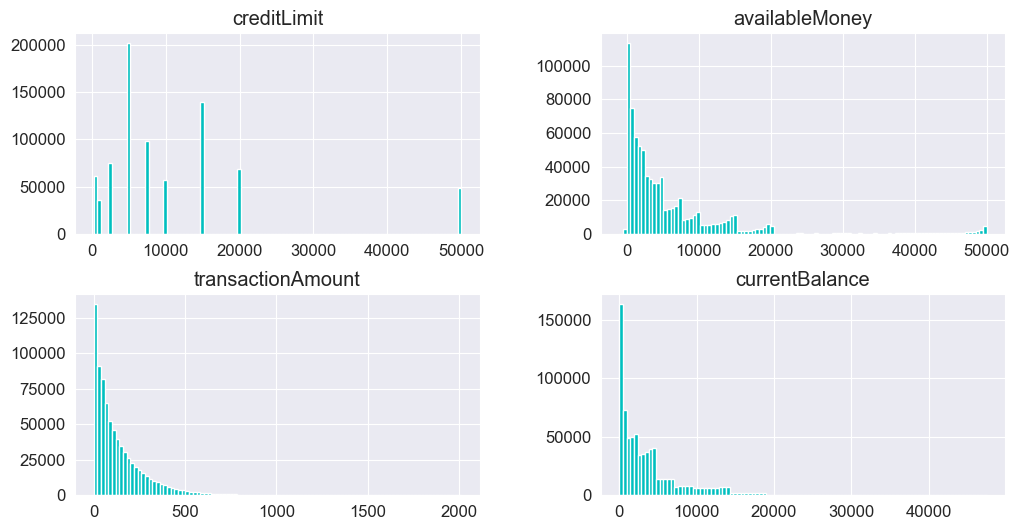

In [184]:
x_num.hist(bins=100,  color='c')


## 3.3 Categorical variables overview

The as-is dataset has 24 non-numerical variables, 4 datetime, 20 categorical/boolean. 

- There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags.
- The columns ['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'] are supposed to be datetimes. Cconvert them to datetime objects.
- Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to 0s and 1s.

In [185]:
# deselect numerical columns and drop the label column
x_cat = x.select_dtypes(exclude='number')
x_cat.head()

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,737265056,737265056,2016-08-13 14:27:32,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,,,,False,,,False
1,737265056,737265056,2016-10-11 05:05:54,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,True,,,False
2,737265056,737265056,2016-11-08 09:18:39,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False
3,737265056,737265056,2016-12-10 02:14:50,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False
4,830329091,830329091,2016-03-24 21:04:46,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False


In [186]:
# replace empty strings with np.nan while downcasting the changed columns' data types
pd.set_option('future.no_silent_downcasting', True)
x_cat = x_cat.replace(r'^\s*$', np.nan, regex=True)

In [187]:
# convert the datetime columns to datetime objects
x_cat['accountOpenDate'] = pd.to_datetime(x_cat['accountOpenDate'])
x_cat['dateOfLastAddressChange'] = pd.to_datetime(x_cat['dateOfLastAddressChange'])
x_cat['transactionDateTime'] = pd.to_datetime(x_cat['transactionDateTime'])

In [188]:
# Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to integers
x_cat['cardPresent'] = x_cat['cardPresent'].astype(int)
x_cat['expirationDateKeyInMatch'] = x_cat['expirationDateKeyInMatch'].astype(int)

## 3.4 Missing values 

- The label column has no missing values.
- The numerical columns have no missing values.
- The categorical columns have missing values. We'd like to be conservative and do imputations univariately and accordingly.
 1. 3.4.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']
 2. 3.4.2 The column ['acqCountry'] has 4562 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be imputed by the mode of the rows with the same ['accountNumber','cardLast4Digits'] columns' combination primarily or by ['accountNumber'] column itself secondarily.
 3. 3.4.3 The column ['merchantCountryCode'] has 724 missing values. The missing seems to be most likely missing not at random(MNAR). The missing values will be imputed by the mode of the rows with ['merchantName'] column primarily .
 4. 3.4.4  3.4.4 The column ['transactionType'] has 698 missing values. Due to lack of relative information, we simply label the missing values as 'Unknown' for now. 
 5. 3.4.5 The column ['posConditionCode'] has 409 missing values. Due to the contradicting code from transactions made at the same merchant, we simply label the missing values as 'Unknown' for now.
 6. 3.4.6 The column ['posEntryMode'] has 4054 missing values. Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now.  

In [189]:
# make a copy of the as-is x_cat dataframe
xc = x_cat.copy()

In [190]:
# check the missing values in the rest columns
x_cat.isna().sum().sort_values(ascending=False)

recurringAuthInd            786363
posOnPremises               786363
merchantZip                 786363
merchantState               786363
merchantCity                786363
echoBuffer                  786363
acqCountry                    4562
posEntryMode                  4054
merchantCountryCode            724
transactionType                698
posConditionCode               409
accountNumber                    0
cardLast4Digits                  0
cardPresent                      0
cardCVV                          0
enteredCVV                       0
customerId                       0
dateOfLastAddressChange          0
accountOpenDate                  0
currentExpDate                   0
merchantCategoryCode             0
merchantName                     0
transactionDateTime              0
expirationDateKeyInMatch         0
dtype: int64

### 3.4.1 Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

There are empty strings in the dataset whom should be regarded as missing values, and we used the regular expression to convert the empty strings to np.nan. As a result, we found 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but np.nans, mostly like they do it intentionally to anonymize some geographic and POS tags. Then drop them all.

In [191]:
# drop the six all NaN columns
x_cat.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)

In [192]:
# check the missing values in the rest columns
x_cat.isna().sum().sort_values(ascending=False)

acqCountry                  4562
posEntryMode                4054
merchantCountryCode          724
transactionType              698
posConditionCode             409
accountNumber                  0
dateOfLastAddressChange        0
cardPresent                    0
cardLast4Digits                0
enteredCVV                     0
cardCVV                        0
currentExpDate                 0
accountOpenDate                0
customerId                     0
merchantCategoryCode           0
merchantName                   0
transactionDateTime            0
expirationDateKeyInMatch       0
dtype: int64

### 3.4.2 The column ['acqCountry'] has 4,562 missing values.
- Among the missing values in the 'acqCountry' column, 3.3% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 4,562 transactions with missing values come from 1,495 accounts. 
- We will impute them by the mode of the rows with the same ['accountNumber'] primarily.
- For 1,494 accounts that can have a mode value. Due to the fact the dataset is predominantly from the US customers, their modes are all US actually. 
- The remaining 1 account,'997884003', who has no record of 'acqCountry' only have 3 non-default transactions from apple's appstore, we will assume it with 'US' as well for now. They can also be dropped later on if they are not informative.

In [193]:
# check the missing values in the 'acqCountry' column's distribution by the label column
y[x_cat['acqCountry'].isna()].value_counts()/ y[x_cat['acqCountry'].isna()].shape[0]

isFraud
0    0.967339
1    0.032661
Name: count, dtype: float64

In [194]:
# check the unique values of the 'accountNumber' of the transactions having missing values in the 'acqCountry' column
a = x_cat[x_cat['acqCountry'].isna()][['accountNumber']].drop_duplicates()
# check the mode of the 'acqCountry' column by the ['accountNumber'] column's group
b = x_cat[x_cat['accountNumber'].isin(a['accountNumber'])][['accountNumber','acqCountry']].groupby(['accountNumber']).agg(pd.Series.mode).astype(str)
b['acqCountry'].value_counts().reset_index()

,acqCountry,count
0,US,1494
1,[],1


In [195]:
b[b['acqCountry'] != 'US']

,acqCountry
accountNumber,
997884003,[]


In [196]:
df[df['accountNumber']=='997884003']

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
107475,997884003,997884003,7500.0,7500.0,2016-10-27 20:48:49,8.98,Apple iTunes,,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,False,False,False
107476,997884003,997884003,7500.0,7500.0,2016-11-27 04:49:57,8.98,Apple iTunes,,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,False,False,False
107477,997884003,997884003,7500.0,7500.0,2016-12-28 23:09:24,8.98,Apple iTunes,,US,09,08,mobileapps,12/2028,2014-11-20,2014-11-20,101,101,9397,PURCHASE,0.0,False,False,False


In [197]:
# impute 'acqCountry' as US for its missing for all accounts for now
x_cat.loc[x_cat['acqCountry'].isna(),'acqCountry'] = 'US'

### 3.4.3 The column ['merchantCountryCode'] has 724 missing values.
- Among the missing values in the 'acqCountry' column, 1.1% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- The 724 transactions with missing values come from 293 merchants. 
- We will impute them by the mode of the rows with the same ['merchantName'] primarily.
- Due to the fact the dataset is predominantly from the US merchants, their modes are all US. 

In [198]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['merchantCountryCode'].isna()].value_counts()/ y[x_cat['merchantCountryCode'].isna()].shape[0]

isFraud
0    0.88674
1    0.11326
Name: count, dtype: float64

In [199]:
# check the unique values of the ['merchantName','merchantCategoryCode'] of the transactions having missing values in the 'merchantCountryCode' column
a = x_cat[x_cat['merchantCountryCode'].isna()][['merchantCountryCode','merchantName','merchantCategoryCode']].drop_duplicates()
# check the mode of the 'merchantCountryCode' column by the 'merchantName' column's group
b = x_cat[x_cat['merchantName'].isin(a['merchantName'])][['merchantName','merchantCountryCode']].groupby(['merchantName']).agg(pd.Series.mode).astype(str)
b['merchantCountryCode'].value_counts().reset_index()

,merchantCountryCode,count
0,US,293


In [200]:
# impute 'merchantCountryCode' as US for its missing for all merchants
x_cat.loc[x_cat['merchantCountryCode'].isna(),'merchantCountryCode'] = 'US'

### 3.4.4 The column ['transactionType'] has 698 missing values.
- Among the missing values in the 'acqCountry' column, 2.0% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to lack of relative information, we simply label the missing values as 'Unknown' for now. 

In [201]:
x_cat['transactionType'].value_counts(dropna=False)

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
NaN                        698
Name: count, dtype: int64

In [202]:
y[x_cat['transactionType'].isna()].value_counts()/ y[x_cat['transactionType'].isna()].shape[0]

isFraud
0    0.979943
1    0.020057
Name: count, dtype: float64

In [203]:
# impute 'transactionType' as 'Unknown' for its missing for all transactions
x_cat.loc[x_cat['transactionType'].isna(),'transactionType'] = 'Unknown'

### 3.4.5 The column ['posConditionCode'] has 409 missing values.
- Among the missing values in the 'acqCountry' column, 5.4% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the contradicting code from transactions made at the same merchant, we simply label the missing values as 'Unknown' for now. 

In [204]:
# check the missing values in the ['merchantCountryCode'] column's distribution by the label column
y[x_cat['posConditionCode'].isna()].value_counts()/ y[x_cat['posConditionCode'].isna()].shape[0]

isFraud
0    0.94621
1    0.05379
Name: count, dtype: float64

In [205]:
x_cat['posConditionCode'].value_counts(dropna=False)

posConditionCode
01     628787
08     149634
99       7533
NaN       409
Name: count, dtype: int64

In [206]:
x_cat.loc[x_cat['posConditionCode'].isna(),['merchantName']].value_counts(dropna=False) 

merchantName        
Shell Gas #256420       25
Lyft                    19
walmart.com             15
Uber                    13
cheapfast.com           12
                        ..
Franks Pub #960098       1
Franks Sandwitch Bar     1
Golds Gym #195674        1
Hardee's #758387         1
williamssonoma.com       1
Name: count, Length: 190, dtype: int64

In [207]:
x_cat.loc[(x_cat['merchantName'] == 'Shell Gas #256420') ,'posConditionCode'].value_counts(dropna=False)

posConditionCode
01     185
NaN     25
08      14
Name: count, dtype: int64

In [208]:
x_cat.loc[x_cat['merchantName'] == 'Lyft','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     20284
08      4974
99       246
NaN       19
Name: count, dtype: int64

In [209]:
x_cat.loc[x_cat['merchantName'] == 'walmart.com','posConditionCode'].value_counts(dropna=False)

posConditionCode
01     13447
08      3246
99       165
NaN       15
Name: count, dtype: int64

In [210]:
# impute 'posConditionCode' as 'Unknown' for its missing for all transactions
x_cat.loc[x_cat['posConditionCode'].isna(),'posConditionCode'] = 'Unknown'

### 3.4.6 The column ['posEntryMode'] has 4,054 missing values.
- Among the missing values in the 'acqCountry' column, 6.6% are fraudulent. They are most likely missing completely at random(MCAR), albeit sufficient checks on the group characteristics between the missing and non-missing.
- Due to the same reason as column ['posConditionCode'], we simply label the missing values as 'Unknown' for now. 

In [211]:
# check the missing values in the ['posEntryMode'] column's distribution by the label column
y[x_cat['posEntryMode'].isna()].value_counts()/ y[x_cat['posEntryMode'].isna()].shape[0]

isFraud
0    0.933646
1    0.066354
Name: count, dtype: float64

In [212]:
# impute 'posEntryMode' as 'Unknown' for its missing for all transactions
x_cat.loc[x_cat['posEntryMode'].isna(),'posEntryMode'] = 'Unknown'

In [213]:
# verify all missing values have been imputed
x_cat.isna().sum().sum()

0

## 3.5 Outliers 
- As aforementioned, the numerical columns display wide ranges and gigantic skewness. So, we will Box-Cox transform them to make them more Gaussian-like, then use eye-balling and the Tukey's fences method to detect the outliers and cap them by the fences.
- It's obvious that our 4 numerical columns are highly correlated by definition. Thus, we only need to detect and handle the outliers for the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns.
- Since we plan to work with Box-Cox transformed columns in the modeling phase, so we will be conservative in the outlier detection and cap them by the Tukey's fences method with k=2.
- As a result, 11 outliers are detected with transaction amount higher than 1680.00, and they are all non-fraudulent transactions.


In [214]:
# Box-Cox transformation every ['creditLimit','transactionAmount','availableMoney'] column in x_num with lambda=0.25
x_num_bc = x_num.copy()
x_num_bc['bc_creditLimit'] = sp.stats.boxcox(x_num['creditLimit'],lmbda=0.25)
x_num_bc['bc_transactionAmount'] = sp.stats.boxcox(x_num['transactionAmount'],lmbda=0.25)
x_num_bc['bc_availableMoney'] = sp.stats.boxcox(x_num['availableMoney'],lmbda=0.25)
# drop the original columns
x_num_bc.drop(columns=['creditLimit','transactionAmount','availableMoney'], inplace=True)
# hstack x_xum_bc with y
x_num_bc = pd.concat([x_num_bc, y], axis=1)

In [215]:
x_num_bc.describe()

,currentBalance,bc_creditLimit,bc_transactionAmount,bc_availableMoney,isFraud
count,786363.000000,786363.000000,786363.000000,783432.000000,786363.000000
mean,4508.739089,32.962360,8.045755,26.692054,0.015790
std,6457.442068,10.124805,4.109909,10.489219,0.124664
min,0.000000,11.905415,-4.000000,-2.108517,0.000000
25%,689.910000,29.635857,5.633991,19.016807,0.000000
50%,2451.760000,33.224194,8.247775,26.103727,0.000000
75%,5291.095000,40.267277,10.879586,33.224194,0.000000
max,47498.810000,55.813951,22.788115,55.813951,1.000000


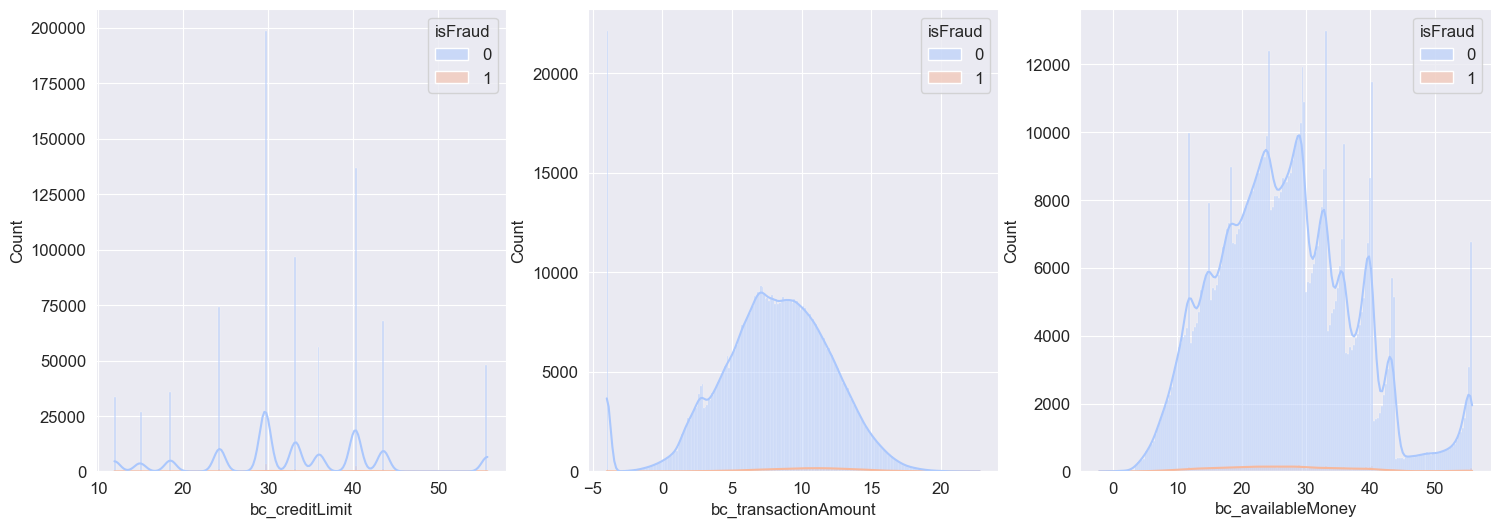

In [216]:
# use seaborn to check the histograms of the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns of isFraud=0or1 group separately with the kde on 
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(x_num_bc, x='bc_creditLimit', hue='isFraud', kde=True, ax=ax[0], palette='coolwarm')
sns.histplot(x_num_bc, x='bc_transactionAmount', hue='isFraud', kde=True, ax=ax[1], palette='coolwarm')
sns.histplot(x_num_bc, x='bc_availableMoney', hue='isFraud', kde=True, ax=ax[2], palette='coolwarm')
plt.show()

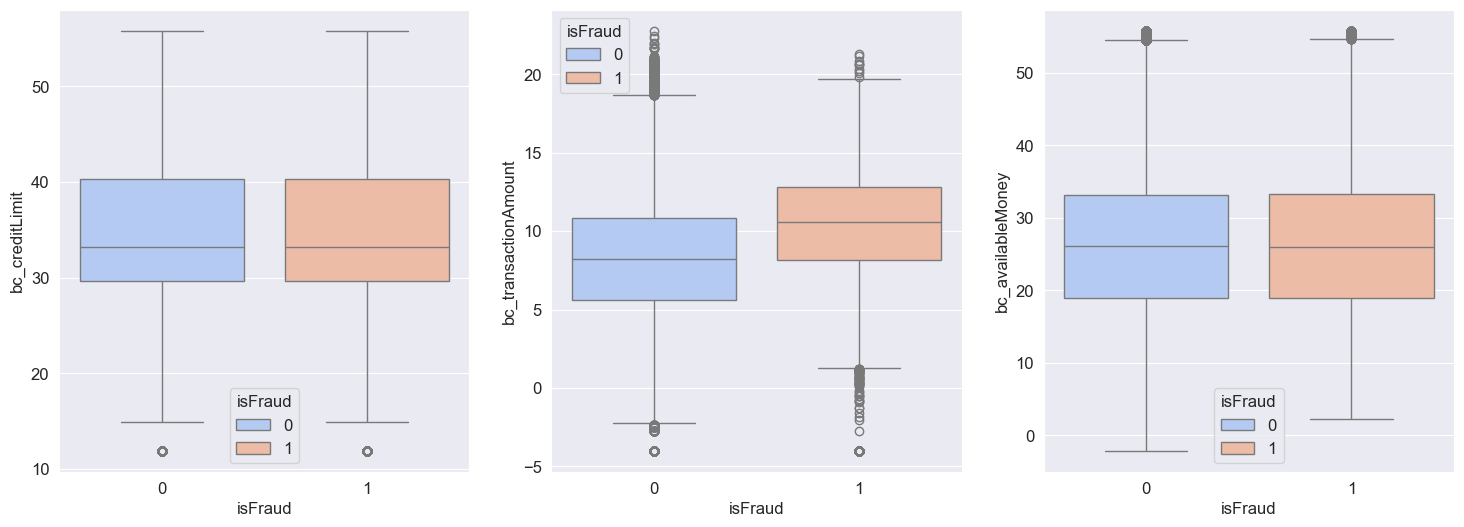

In [217]:
# use sns to plot the boxplot of the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns isFraud=0or1 group with different color
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.boxplot(x='isFraud', y='bc_creditLimit', data=x_num_bc, ax=ax[0], hue='isFraud', palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_transactionAmount', data=x_num_bc, ax=ax[1], hue='isFraud',palette='coolwarm')
sns.boxplot(x='isFraud', y='bc_availableMoney', data=x_num_bc, ax=ax[2], hue='isFraud',palette='coolwarm')
plt.show()

In [218]:
# use the Tukey's fense method to detect the outliers in the Box-Cox transformed ['creditLimit','transactionAmount','availableMoney'] columns
k = 2
def tukey_fences(x, k):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))
a = tukey_fences(x_num_bc['bc_creditLimit'],k=k).sum()
b = tukey_fences(x_num_bc['bc_transactionAmount'],k=k).sum()
c = tukey_fences(x_num_bc['bc_availableMoney'],k=k).sum()
print(f'bc_creditLimit has {a} outliers when we set the k = {k}.')
print(f'bc_transactionAmount has {b} outliers when we set the k = {k}.')
print(f'bc_availableMoney has {c} outliers when we set the k = {k}.')

bc_creditLimit has 0 outliers when we set the k = 2.
bc_transactionAmount has 11 outliers when we set the k = 2.
bc_availableMoney has 0 outliers when we set the k = 2.


In [219]:
# find the top 11 transactions with the largest transactionAmount
outlier_index = x_num.nlargest(11, 'transactionAmount').index
df.loc[outlier_index].sort_values(['transactionAmount'], ascending=False)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
380125,716595213,716595213,50000.0,47991.66,2016-03-28 11:25:42,2011.54,discount.com,US,US,05,01,online_retail,03/2027,2015-06-28,2015-06-28,278,278,4457,PURCHASE,2008.34,False,False,False
498620,875460072,875460072,20000.0,18259.98,2016-05-23 20:09:24,1905.30,In-N-Out #659625,US,US,05,08,fastfood,03/2029,2015-12-28,2015-12-28,443,443,2229,PURCHASE,1740.02,True,False,False
673073,726728113,726728113,15000.0,10484.42,2016-02-26 00:45:21,1873.97,Dinosaur Sandwitch Bar #249717,US,US,02,01,food,10/2032,2010-11-09,2010-11-09,319,319,3618,PURCHASE,4515.58,True,False,False
778423,748247730,748247730,10000.0,9006.27,2016-04-26 20:14:53,1780.60,alibaba.com,US,US,05,01,online_retail,05/2021,2012-09-06,2012-09-06,607,607,1883,PURCHASE,993.73,False,False,False
424567,710219416,710219416,2500.0,1129.87,2016-10-05 05:06:51,1772.63,Burger King #862268,US,US,05,01,fastfood,01/2028,2009-05-19,2016-02-07,449,449,2445,PURCHASE,1370.13,True,False,False
612391,614394290,614394290,15000.0,4225.92,2016-09-12 15:41:39,1767.50,Planet Fitness #527068,US,US,05,01,health,08/2021,2015-01-12,2015-01-12,233,233,905,PURCHASE,10774.08,False,False,False
679917,380083836,380083836,5000.0,346.02,2016-10-28 20:36:51,1710.13,Ricks Repair,US,US,09,08,auto,01/2032,2015-12-23,2016-10-21,738,738,7185,PURCHASE,4653.98,True,False,False
371878,865635967,865635967,500.0,142.21,2016-12-26 07:48:01,1707.80,34th BBQ #436606,US,US,05,01,food,03/2032,2015-04-23,2016-12-12,909,909,1149,PURCHASE,357.79,True,False,False
308817,654507597,654507597,500.0,480.98,2016-07-20 23:33:20,1704.55,Shake Shack #235531,US,US,02,01,fastfood,12/2021,2013-11-23,2016-07-02,748,748,4127,PURCHASE,19.02,False,False,False
501537,788948518,788948518,15000.0,15000.00,2016-12-01 21:07:03,1693.36,Shake Shack #235531,US,US,09,01,fastfood,05/2022,2014-12-05,2016-06-29,115,115,787,PURCHASE,0.00,True,False,False


In [220]:
# delete the 11 outliers from df
df.drop(index=outlier_index, inplace=True)
df.reset_index(drop=True, inplace=True)

## 3.6 Feature Engineering

The as-is dataset has 4 numerical features and 24 non-numerical features, 4 datetime, 20 categorical/boolean. The post-preprocessed dataset will have 3 numerical features and 16 categorical features, 4 datetime, 12 categorical/boolean, after we discard the non-informative columns and re-construct the verbose ones.

1. The column ['currentBalance'] will be dropped because it is the difference between the ['creditLimit'] and ['availableMoney'] columns.
2. Note the ['accountNumber'] and ['customerId'] columns are identical. We will drop the customerId column.
3. The column ['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'] are datetime columns. We will convert them to datetime objects.
4. The column ['currentExpDate'] is a string column in format mm/yy. We will convert it to a datetime object by impute them to the last day of the month. We first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
5. Extract the 'x_hour', 'x_day_of_week', 'x_day_of_month', 'x_month', 'x_year', 'day_since_open', 'day_since_update_add', and 'day_2_exp' from the existing columns and drop the original ones.
6. Coalesce the information contained in ['cardCVV', 'enteredCVV'] columns to a new categorical ['mismatchInCVV'] column showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns. And we restrain from diving into the analysis of which of the integers cause mismatches for now.
7. Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to binary for the convenience of modeling.
8. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205. __Maybe we can further reduce the number of merchants by grouping the tail 20%__.

In [221]:
# 1. drop the 'currentBalance' column from df
df.drop(columns='currentBalance', inplace=True)

In [222]:
# 2. drop the customerId column for duplication from df
df.customerId.equals(df.accountNumber)
df.drop(columns='customerId', inplace=True)


In [223]:
# 3. convert the datetime columns to datetime objects
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

In [224]:
# 4. impute the format mm/yy to the last day of the month of the column currentExpDate by first convert to the 1st day of the month, then add 1 month and subtract 1 day, finally convert it to datetime objects.
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'].apply(lambda x: '01/' + x),dayfirst=True) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

In [225]:
# 5. extract the 'x_hr', 'x_d', 'x_DOW', 'x_mon', 'x_yr', 't_since_open', 't_since_update_add', and 't_2_exp' from the existing columns and drop the original ones
df['x_hr'] = df['transactionDateTime'].dt.hour
df['x_d'] = df['transactionDateTime'].dt.day
df['x_DOW'] = df['transactionDateTime'].dt.dayofweek
df['x_mon'] = df['transactionDateTime'].dt.month
df['x_yr'] = df['transactionDateTime'].dt.year
df['t_since_open'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
df['t_since_update_add'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
df['t_2_exp'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
# drop the original columns
df.drop(columns=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime', 'currentExpDate'], inplace=True)

In [226]:
# 6. convert the 3 integers in each row of 'cardCVV' and 'enteredCVV' columns to  new ndarrays with 3 columns of integers
a = np.stack(df['cardCVV'].map(lambda x: list(map(int, x))).to_list())
b = np.stack(df['enteredCVV'].map(lambda x: list(map(int, x))).to_list())
# create a new column 'mismatchInCVV' showing the number of mismatches by comparing the 3 integers in each row of the two aforementioned columns
df['mismatchInCVV'] = pd.Series(np.sum(a != b, axis=1)).astype(np.short)
# drop the 'cardCVV' and 'enteredCVV' columns
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)

In [227]:
# 7. Convert the boolean columns ['cardPresent', 'expirationDateKeyInMatch] to binary for the convenience of modeling.
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [228]:
# 8. Truncate the ['merchantName'] starting from the first #, reducing the number of merchants from 2489 to 205.
df['merchantName'] = df['merchantName'].str.split('#').str[0]
df['merchantName'].nunique()

205

In [229]:
# split the df into y, x_num and x_cat, and get the x_num_bc via Box-Cox transformation with lambda=0.25
y = df['isFraud']
x_num = df[['creditLimit', 'availableMoney', 'transactionAmount']]
x_num_bc = x_num.copy()
x_num_bc['bc_creditLimit'] = sp.stats.boxcox(x_num['creditLimit'],lmbda=0.25)
x_num_bc['bc_transactionAmount'] = sp.stats.boxcox(x_num['transactionAmount'],lmbda=0.25)
x_num_bc['bc_availableMoney'] = sp.stats.boxcox(x_num['availableMoney'],lmbda=0.25)
# drop the original columns
x_num_bc.drop(columns=['creditLimit','transactionAmount','availableMoney'], inplace=True)
# hstack x_xum_bc with y
x_num_bc = pd.concat([x_num_bc, y], axis=1)
x_cat = df.drop(columns=['creditLimit', 'availableMoney', 'transactionAmount', 'isFraud'])
x_num.describe()

,creditLimit,availableMoney,transactionAmount
count,786352.000000,786352.000000,786352.000000
mean,10759.438839,6250.676007,136.962760
std,11636.145634,8880.691639,147.597735
min,250.000000,-1005.630000,0.000000
25%,5000.000000,1077.420000,33.650000
50%,7500.000000,3184.855000,87.900000
75%,15000.000000,7500.000000,191.472500
max,50000.000000,50000.000000,1608.350000


In [230]:
x_cat = df[['accountNumber',
    'cardLast4Digits',
    'acqCountry',
 'transactionType',
 'merchantName',
 'merchantCountryCode',
 'merchantCategoryCode',
 'posEntryMode',
 'posConditionCode',
 'cardPresent',
 'expirationDateKeyInMatch',
 'mismatchInCVV',
 'x_hr',
 'x_d',
 'x_DOW',
 'x_mon',
 'x_yr',
 't_since_open',
 't_since_update_add',
 't_2_exp']]
x_cat.head()

,accountNumber,cardLast4Digits,acqCountry,transactionType,merchantName,merchantCountryCode,merchantCategoryCode,posEntryMode,posConditionCode,cardPresent,expirationDateKeyInMatch,mismatchInCVV,x_hr,x_d,x_DOW,x_mon,x_yr,t_since_open,t_since_update_add,t_2_exp
0,737265056,1803,US,PURCHASE,Uber,US,rideshare,02,01,0,0,0,14,13,5,8,2016,518,518,-2512
1,737265056,767,US,PURCHASE,AMC,US,entertainment,09,01,1,0,0,5,11,1,10,2016,577,577,-2697
2,737265056,767,US,PURCHASE,Play Store,US,mobileapps,09,01,0,0,0,9,8,1,11,2016,605,605,-3218
3,737265056,767,US,PURCHASE,Play Store,US,mobileapps,09,01,0,0,0,2,10,5,12,2016,637,637,-3186
4,830329091,3143,US,PURCHASE,Tim Hortons,US,fastfood,02,01,1,0,0,21,24,3,3,2016,231,231,-4969


## 4. Exploratory Data Analysis

In [245]:
## 4.1 Numerical Features
sns.violinplot(x='isFraud', y='creditLimit', data=x_num_bc, ax=ax[0], hue='isFraud', palette='coolwarm', fill=False, inner='quart', legend=False, split=True, cut=0)

ValueError: Could not interpret value `creditLimit` for `y`. An entry with this name does not appear in `data`.

ValueError: Could not interpret value `bc_currentBalance` for `y`. An entry with this name does not appear in `data`.

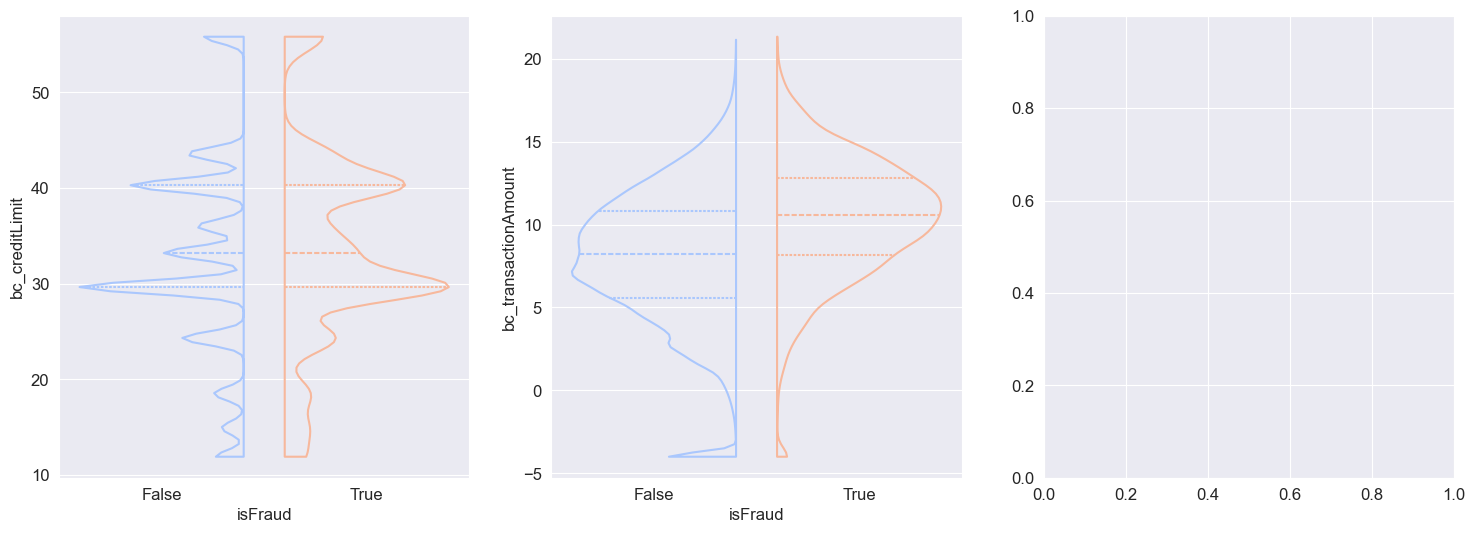

In [246]:
# Box plot of the log-transformed numerical features by the label column, change the y label to log(creditLimit), log(transactionAmount), and log(currentBalance)
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.violinplot(x='isFraud', y='bc_creditLimit', data=x_num_bc, ax=ax[0], hue='isFraud', palette='coolwarm', fill=False, inner='quart', legend=False, split=True, cut=0)
sns.violinplot(x='isFraud', y='bc_transactionAmount', data=x_num_bc, ax=ax[1], hue='isFraud', palette='coolwarm', fill=False, inner='quart', legend=False, split=True, cut=0)
sns.violinplot(x='isFraud', y='bc_currentBalance', data=x_num_bc, ax=ax[2], hue='isFraud', palette='coolwarm', fill=False, inner='quart', legend=False, split=True, cut=0)
ax[0].set_ylabel('creditLimit')
ax[1].set_ylabel('transactionAmount')
ax[2].set_ylabel('currentBalance')
# change the y axis to the Box-Cox transformed values with lambda=0.25
ax[0].set_yticklabels(np.round(sp.special.inv_boxcox(ax[0].get_yticks(),0.25),2))
ax[1].set_yticklabels(np.round(sp.special.inv_boxcox(ax[1].get_yticks(),0.25),2))
ax[2].set_yticklabels(np.round(sp.special.inv_boxcox(ax[2].get_yticks(),0.25),2))
plt.show()

In [ ]:
last 4 digits with only 3 numbers. Capital One does not issue credit cards in the American Express (Amex) network.

In [ ]:
no idea what echoBuffer is

In [ ]:
posonpremises is legacy pos with physical infrastructure, right?

In [ ]:
The term "expirationdatekeyinmatch" typically refers to a situation where a system or software prompts a user to input or match an expiration date for verification or authentication purposes. It could be part of a security protocol where a user is required to enter a specific expiration date associated with a card, document, or other credential to confirm its validity or access rights. This term is commonly used in contexts such as payment processing, access control systems, or any situation where validating the expiration of a document or credential is necessary.

posConditionCode: It is a code identifying transaction conditions at the point-of-sale. https://www.mreports.com/documentation/ac/nonmerchant/80449.htm
posEntryMode: It identifies the actual method used to enter the cardholder account number and card expiration date. This code specifies whether the entire magnetic stripe is included in an authorization
if request. https://www.mreports.com/documentation/ac/nonmerchant/80451.htm
       